In [1]:
from pathlib import Path

PROJECT_FOLDER_PATH = Path("/content/drive/MyDrive/images_hw_1")

## Set up Colab

In [2]:
%pip install -qU python-dotenv pytorch-ignite onnx onnxscript torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.8/686.8 kB 38.8 MB/s eta 0:00:00


In [3]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
# Add src module
import sys

sys.path.insert(
    0, str(PROJECT_FOLDER_PATH)
)
print(sys.path)

['/content/drive/MyDrive/images_hw_1', '/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/usr/local/lib/python3.10/dist-packages/setuptools/_vendor', '/root/.ipython']


In [5]:
# Unzip dataset
!mkdir -p ./data/cityscapes
!unzip -qo "{str(PROJECT_FOLDER_PATH)}/cityscapes_data/gtFine_trainvaltest.zip" -d ./data/cityscapes
!unzip -qo "{str(PROJECT_FOLDER_PATH)}/cityscapes_data/leftImg8bit_trainvaltest.zip" -d ./data/cityscapes

## Set up notebook

In [6]:
%load_ext autoreload
%autoreload 2

In [ ]:
import multiprocessing
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from dotenv import load_dotenv
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.auto import tqdm

import wandb
from src.cityscapes_data_handler import Cityscapes, show_images_side_by_side
from src.metrics import Metrics
from src.trainer import Trainer
from src.unet import UNet

In [8]:
# Supress torch dynamo warnings
import torch._dynamo

torch._dynamo.config.suppress_errors = True

In [9]:
# Load wandb key

# Local
# load_dotenv()

# Colab
from google.colab import userdata

WANDB_KEY = userdata.get("WANDB_KEY")

In [10]:
# Define contants

CITYSCAPES_FOLDER = Path("./data/cityscapes")
DTYPE = torch.bfloat16

# Dataset contants
cityscapes_dataset = Cityscapes(
    CITYSCAPES_FOLDER, split="train", is_transform=True, img_size=[512, 1024], dtype=DTYPE
)
IGNORE_INDEX = cityscapes_dataset.ignore_index
N_CLASSES = cityscapes_dataset.n_classes

# Construct label idx to label name dict
labels = [
    cityscapes_dataset.class_names[i]
    for i in list(cityscapes_dataset.label_colours.keys())[1:] + [0]
]
IDX2NAME = dict(zip(range(N_CLASSES), labels))
IDX2NAME

Found 2975 train images


{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic_light',
 7: 'traffic_sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'unlabelled'}

In [11]:
# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Overfit small model on a single batch (to validate)

In [ ]:
dataset = Cityscapes(
    CITYSCAPES_FOLDER, split="train", is_transform=True, img_size=[16, 32], dtype=DTYPE
)
loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=multiprocessing.cpu_count())

imgs_batch, lbls_batch = next(iter(loader))
imgs_batch.shape, lbls_batch.shape

Found 2975 train images


(torch.Size([2, 3, 16, 32]), torch.Size([2, 1, 16, 32]))

In [ ]:
unet = UNet(
    img_size=[16, 32],
    in_channels=3,
    depth=1,
    n_classes=N_CLASSES,
    start_channels=4,
    dtype=DTYPE,
).to(device)
# opt_unet = torch.compile(unet)

metrics = Metrics(num_classes=N_CLASSES, idx_to_class_name=IDX2NAME, device=device)

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optim = torch.optim.Adam(unet.parameters(), lr=1e-2)

In [ ]:
loss_hist = []
metrics_hist = []

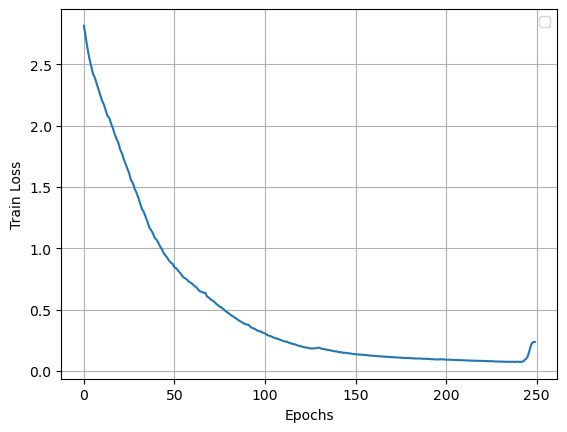

In [ ]:
N_EPOCHS = 250

for _ in tqdm(range(N_EPOCHS)):
    # Train
    optim.zero_grad()
    logits = unet(imgs_batch)
    loss = loss_fn(logits, torch.squeeze(lbls_batch, dim=1).to(dtype=torch.long))
    loss.backward()
    optim.step()

    # Calc metrics
    # 1. Reshape logits and labels
    logits = torch.permute(logits, (0, 2, 3, 1)).reshape(-1, N_CLASSES)
    labels = torch.squeeze(lbls_batch, dim=1).view(-1).to(dtype=torch.long)
    # 2. Calc ignored mask
    ign_mask = labels == IGNORE_INDEX
    # 3. Update metrics
    metrics.update(logits[~ign_mask], labels[~ign_mask])
    metrics_hist.append(metrics.compute())
    metrics.reset()

    # Save loss and plot loss plot
    loss_hist.append(loss.detach().cpu().item())
    clear_output(wait=True)
    plt.plot(loss_hist)
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss")
    plt.legend()
    plt.grid()

    plt.show()

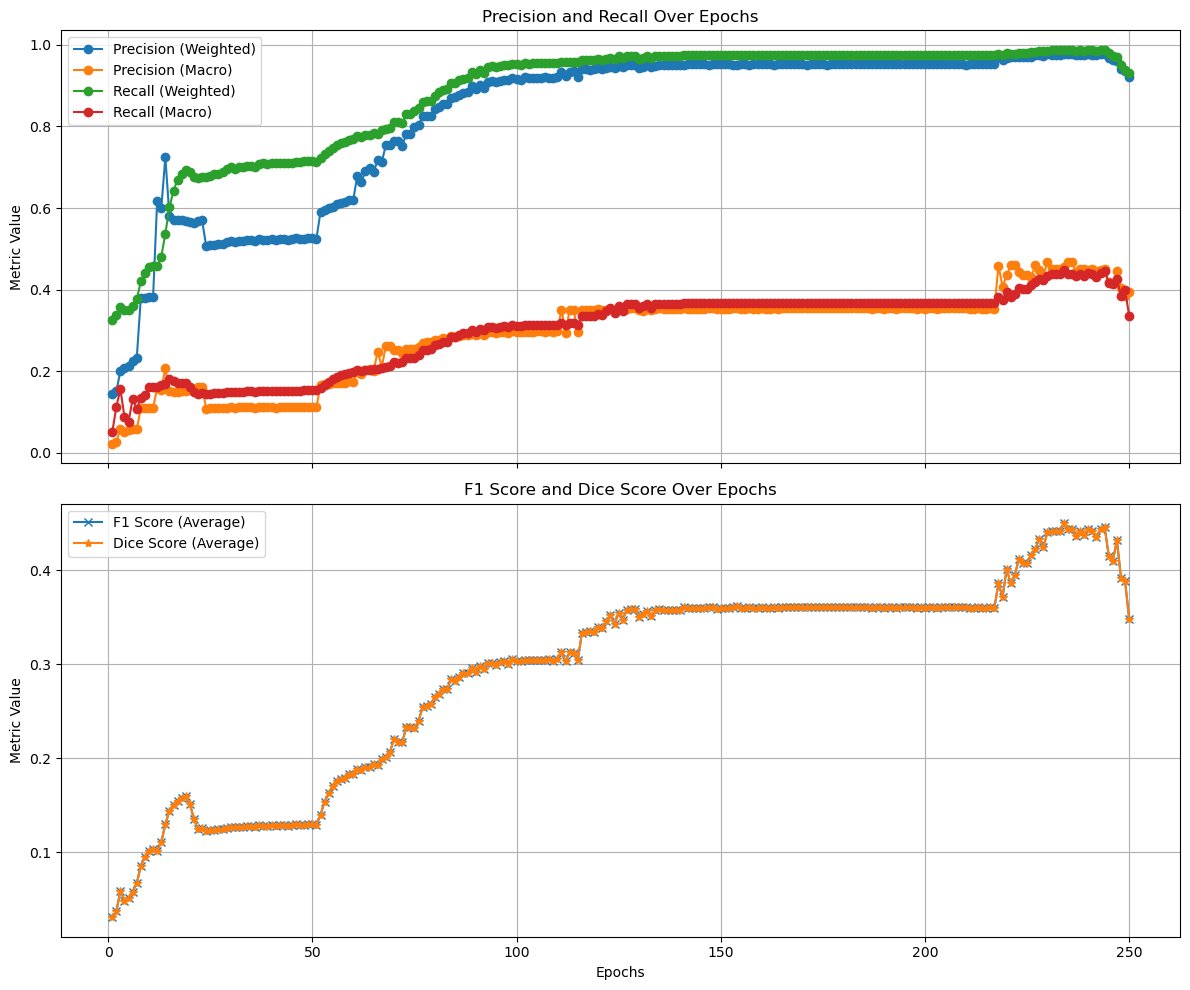

In [ ]:
epochs = list(range(1, len(metrics_hist) + 1))

precision_weighted = [d["precision_weighted"] for d in metrics_hist]
precision_macro = [d["precision_macro"] for d in metrics_hist]

recall_weighted = [d["recall_weighted"] for d in metrics_hist]
recall_macro = [d["recall_macro"] for d in metrics_hist]

f1_avg = [d["f1_avg"] for d in metrics_hist]
dice_avg = [d["dice_avg"] for d in metrics_hist]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Precision and Recall subplot
axes[0].plot(epochs, precision_weighted, label="Precision (Weighted)", marker="o")
axes[0].plot(epochs, precision_macro, label="Precision (Macro)", marker="o")
axes[0].plot(epochs, recall_weighted, label="Recall (Weighted)", marker="o")
axes[0].plot(epochs, recall_macro, label="Recall (Macro)", marker="o")
axes[0].set_title("Precision and Recall Over Epochs")
axes[0].set_ylabel("Metric Value")
axes[0].legend()
axes[0].grid()

# F1 and Dice Score subplot
axes[1].plot(epochs, f1_avg, label="F1 Score (Average)", marker="x")
axes[1].plot(epochs, dice_avg, label="Dice Score (Average)", marker="*")
axes[1].set_title("F1 Score and Dice Score Over Epochs")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Metric Value")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

The spike at the end because of high learning rate.   
Seems like architecture is properly defined and model can learn.

## WandB testing

https://docs.wandb.ai/tutorials/pytorch/

In [ ]:
# Login into wandb

# Local
# wandb.login(key=os.getenv("WANDB_KEY"))

# Colab
wandb.login(key=WANDB_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deniskirbaba (deniskirbaba-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define run hyperparameters
config = dict(
    img_size=(16, 32),
    classes=N_CLASSES,
    architecture="UNet",
    start_channels=4,
    depth=1,
    epochs=2,
    batch_size=4,
    learning_rate=1e-2,
)

In [ ]:
# Init and prepare trainer
trainer = Trainer(
    config=config,
    device=device,
    dtype=DTYPE,
    ignore_index=IGNORE_INDEX,
    idx2name=IDX2NAME,
    project_name="test_wandb",
    model_save_folder=Path(
        "/content/drive/MyDrive/AI Talent Hub/Обработка и генерация изображений/images_hw_1/model_checkpoints/wandb_testing/"
    ),
)
trainer.prepare(cityscapes_folder=CITYSCAPES_FOLDER, subset=True, compile=True)

Found 2975 train images
Found 500 val images


#### Analyze model

In [ ]:
trainer.model

OptimizedModule(
  (_orig_mod): UNet(
    (down_blocks): ModuleList(
      (0): DoubleConv(
        (layer): Sequential(
          (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Hardswish()
          (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Hardswish()
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (layer): Sequential(
            (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
            (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       

In [ ]:
summary(
    trainer.model,
    input_data=torch.zeros(
        size=(config["batch_size"], 3, *config["img_size"]), dtype=DTYPE, device=device
    ),
    mode="train",
)

/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
OptimizedModule                                    [4, 19, 16, 32]           --
├─UNet: 1-1                                        [4, 19, 16, 32]           --
│    └─ModuleList: 2-1                             --                        --
│    │    └─DoubleConv: 3-1                        [4, 4, 16, 32]            276
│    │    └─Sequential: 3-2                        [4, 8, 8, 16]             912
│    └─Sequential: 2-2                             [4, 8, 8, 16]             --
│    │    └─MaxPool2d: 3-3                         [4, 8, 4, 8]              --
│    │    └─DoubleConv: 3-4                        [4, 16, 4, 8]             3,552
│    │    └─ConvTranspose2d: 3-5                   [4, 8, 8, 16]             520
│    └─ModuleList: 2-3                             --                        --
│    │    └─Sequential: 3-6                        [4, 4, 16, 32]            1,908
│    └─Sequential: 2-4    

In [ ]:
model = trainer.run_model_pipeline()

Всё работает, теперь можно попробовать обучить модель побольше и на большем количестве данных.

## Experiment 1

In [ ]:
# Login into wandb

# Local
# wandb.login(key=os.getenv("WANDB_KEY"))

# Colab
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define run hyperparameters
config = dict(
    img_size=(64, 128),
    classes=N_CLASSES,
    architecture="UNet",
    start_channels=8,
    depth=2,
    epochs=5,
    batch_size=256,
    learning_rate=1e-3,
)

In [ ]:
# Init and prepare trainer
trainer = Trainer(
    config=config,
    device=device,
    dtype=DTYPE,
    ignore_index=IGNORE_INDEX,
    idx2name=IDX2NAME,
    project_name="images_hw_1",
    model_save_folder=Path(
        "/content/drive/MyDrive/AI Talent Hub/Обработка и генерация изображений/images_hw_1/model_checkpoints/experiment_1/"
    ),
)
trainer.prepare(cityscapes_folder=CITYSCAPES_FOLDER, subset=False, compile=True)

Found 2975 train images
Found 500 val images


#### Analyze size of model

Batch size tuning happens here

In [ ]:
trainer.model

OptimizedModule(
  (_orig_mod): UNet(
    (down_blocks): ModuleList(
      (0): DoubleConv(
        (layer): Sequential(
          (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Hardswish()
          (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Hardswish()
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (layer): Sequential(
            (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
            (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [ ]:
summary(
    trainer.model,
    input_data=torch.zeros(
        size=(config["batch_size"], 3, *config["img_size"]), dtype=DTYPE, device=device
    ),
    mode="train",
)

Layer (type:depth-idx)                             Output Shape              Param #
OptimizedModule                                    [256, 19, 64, 128]        --
├─UNet: 1-1                                        [256, 19, 64, 128]        --
│    └─ModuleList: 2-1                             --                        --
│    │    └─DoubleConv: 3-1                        [256, 8, 64, 128]         840
│    │    └─Sequential: 3-2                        [256, 16, 32, 64]         3,552
│    │    └─Sequential: 3-3                        [256, 32, 16, 32]         14,016
│    └─Sequential: 2-2                             [256, 32, 16, 32]         --
│    │    └─MaxPool2d: 3-4                         [256, 32, 8, 16]          --
│    │    └─DoubleConv: 3-5                        [256, 64, 8, 16]          55,680
│    │    └─ConvTranspose2d: 3-6                   [256, 32, 16, 32]         8,224
│    └─ModuleList: 2-3                             --                        --
│    │    └─Sequenti

#### Run pipeline

In [ ]:
model = trainer.run_model_pipeline()

#### Examples of model predictions

In [ ]:
# Load best model
model = torch.load(
    Path("/home/denis/Documents/exp1model.pt"), weights_only=False, map_location=device
)

In [ ]:
# Let's pick 5 images from test dataset and predict classes from our model
test_dataset = Cityscapes(
    CITYSCAPES_FOLDER,
    split="test",
    is_transform=True,
    img_size=list(config["img_size"]),
    dtype=DTYPE,
)
test_loader = DataLoader(
    test_dataset, batch_size=5, shuffle=True, num_workers=multiprocessing.cpu_count()
)

imgs, lbls = next(iter(test_loader))
imgs.shape, imgs.dtype

Found 1525 test images


(torch.Size([5, 3, 64, 128]), torch.bfloat16)

In [ ]:
# Get predictions from model
model.eval()
with torch.no_grad():
    logits = model(imgs.to(device))
    preds = logits.argmax(dim=1, keepdim=True)

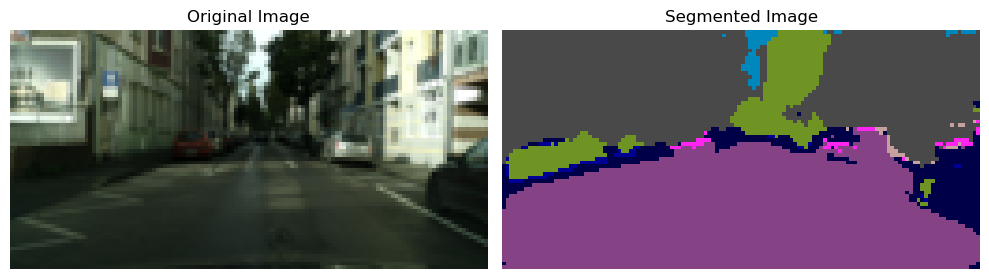

In [ ]:
show_images_side_by_side(imgs[0], test_dataset.decode_segmap(preds[0]))

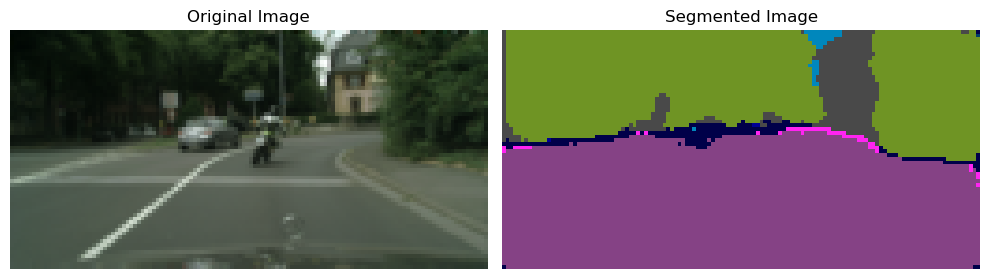

In [ ]:
show_images_side_by_side(imgs[1], test_dataset.decode_segmap(preds[1]))

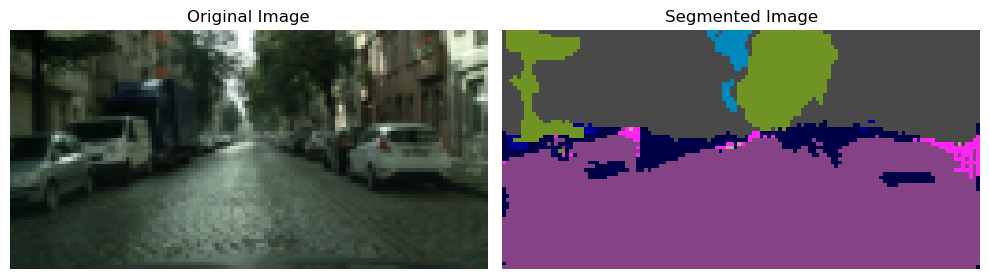

In [ ]:
show_images_side_by_side(imgs[2], test_dataset.decode_segmap(preds[2]))

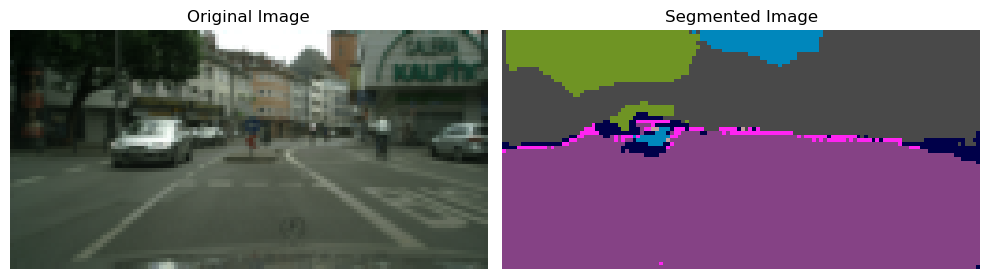

In [ ]:
show_images_side_by_side(imgs[3], test_dataset.decode_segmap(preds[3]))

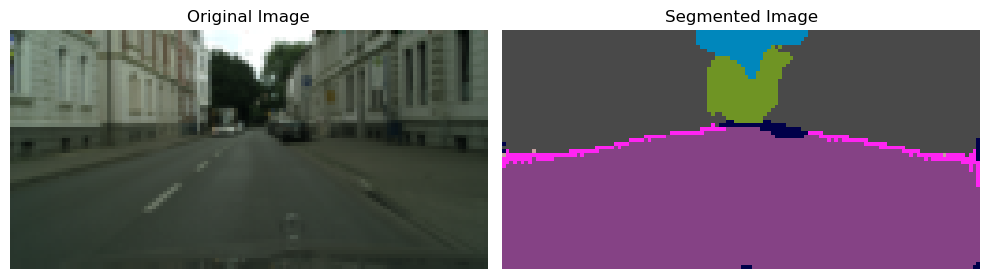

In [ ]:
show_images_side_by_side(imgs[4], test_dataset.decode_segmap(preds[4]))

## Experiment 2

In [ ]:
# Login into wandb

# Local
# wandb.login(key=os.getenv("WANDB_KEY"))

# Colab
wandb.login(key=WANDB_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Define run hyperparameters
config = dict(
    img_size=(64, 128),
    classes=N_CLASSES,
    architecture="UNet",
    start_channels=16,
    depth=3,
    epochs=7,
    batch_size=256,
    learning_rate=1e-3,
)

In [ ]:
# Init and prepare trainer
trainer = Trainer(
    config=config,
    device=device,
    dtype=DTYPE,
    ignore_index=IGNORE_INDEX,
    idx2name=IDX2NAME,
    project_name="images_hw_1",
    model_save_folder=PROJECT_FOLDER_PATH / "model_checkpoints/experiment_2/"
    )

trainer.prepare(cityscapes_folder=CITYSCAPES_FOLDER, subset=False, compile=True)

Found 2975 train images
Found 500 val images


#### Analyze size of model

Batch size tuning happens here

In [ ]:
trainer.model

OptimizedModule(
  (_orig_mod): UNet(
    (down_blocks): ModuleList(
      (0): DoubleConv(
        (layer): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Hardswish()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Hardswish()
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (layer): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
summary(
    trainer.model,
    input_data=torch.zeros(
        size=(config["batch_size"], 3, *config["img_size"]), dtype=DTYPE, device=device
    ),
    mode="train",
)

Layer (type:depth-idx)                             Output Shape              Param #
OptimizedModule                                    [256, 19, 64, 128]        --
├─UNet: 1-1                                        [256, 19, 64, 128]        --
│    └─ModuleList: 2-1                             --                        --
│    │    └─DoubleConv: 3-1                        [256, 16, 64, 128]        2,832
│    │    └─Sequential: 3-2                        [256, 32, 32, 64]         14,016
│    │    └─Sequential: 3-3                        [256, 64, 16, 32]         55,680
│    │    └─Sequential: 3-4                        [256, 128, 8, 16]         221,952
│    └─Sequential: 2-2                             [256, 128, 8, 16]         --
│    │    └─MaxPool2d: 3-5                         [256, 128, 4, 8]          --
│    │    └─DoubleConv: 3-6                        [256, 256, 4, 8]          886,272
│    │    └─ConvTranspose2d: 3-7                   [256, 128, 8, 16]         131,200
│    └─Mo

#### Run pipeline

In [ ]:
model = trainer.run_model_pipeline()

#### Examples of model predictions

In [ ]:
# Load best model
model = torch.load(
    Path("/content/drive/MyDrive/images_hw_1/model_checkpoints/experiment_2/UNet_16_3_7_5.pt"), weights_only=False, map_location=device
)

In [ ]:
# Let's pick 5 images from test dataset and predict classes from our model
test_dataset = Cityscapes(
    CITYSCAPES_FOLDER,
    split="test",
    is_transform=True,
    img_size=list(config["img_size"]),
    dtype=DTYPE,
)
test_loader = DataLoader(
    test_dataset, batch_size=5, shuffle=True, num_workers=multiprocessing.cpu_count()
)

imgs, lbls = next(iter(test_loader))
imgs.shape, imgs.dtype

Found 1525 test images


(torch.Size([5, 3, 64, 128]), torch.bfloat16)

In [ ]:
# Get predictions from model
model.eval()
with torch.no_grad():
    logits = model(imgs.to(device))
    preds = logits.argmax(dim=1, keepdim=True)

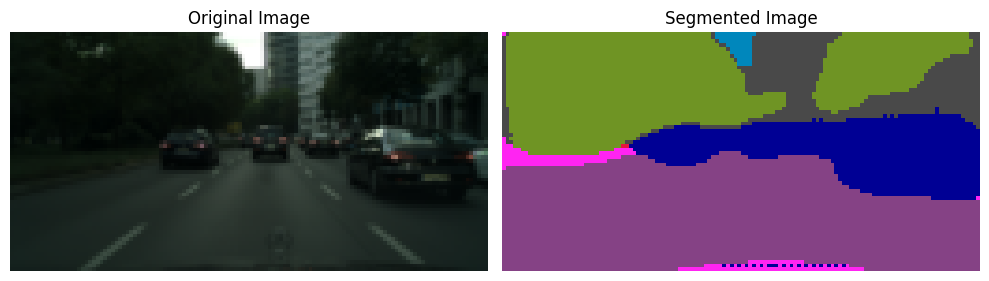

In [ ]:
show_images_side_by_side(imgs[0].detach().cpu(), test_dataset.decode_segmap(preds[0]).detach().cpu())

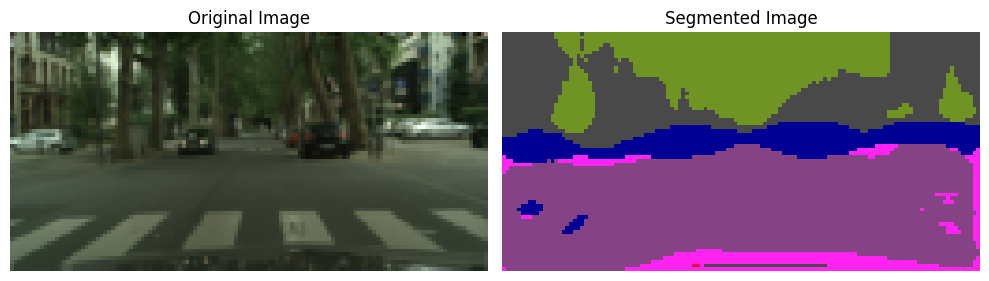

In [ ]:
show_images_side_by_side(imgs[1].detach().cpu(), test_dataset.decode_segmap(preds[1]).detach().cpu())

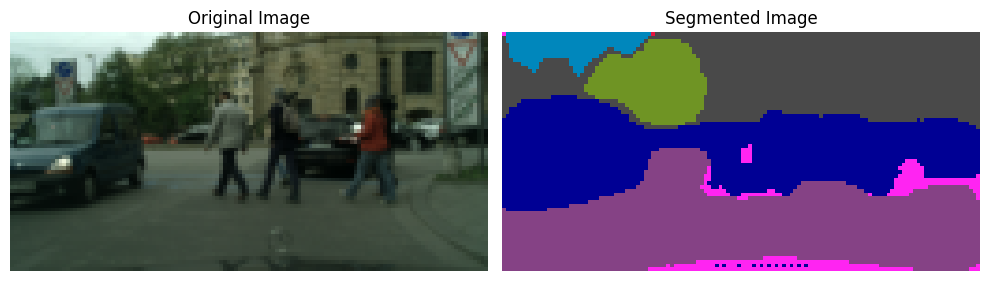

In [ ]:
show_images_side_by_side(imgs[2].detach().cpu(), test_dataset.decode_segmap(preds[2]).detach().cpu())

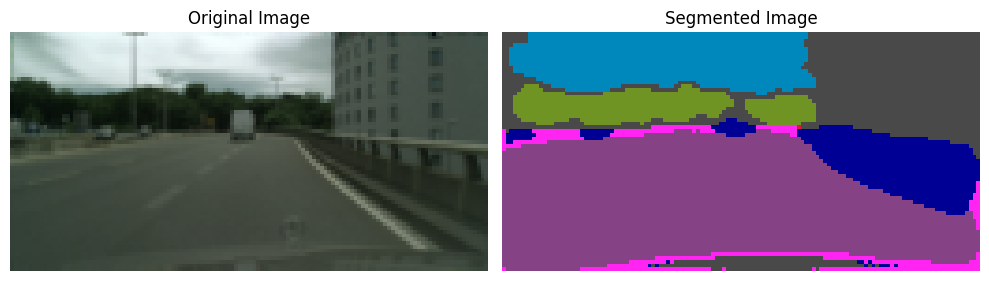

In [ ]:
show_images_side_by_side(imgs[3].detach().cpu(), test_dataset.decode_segmap(preds[3]).detach().cpu())

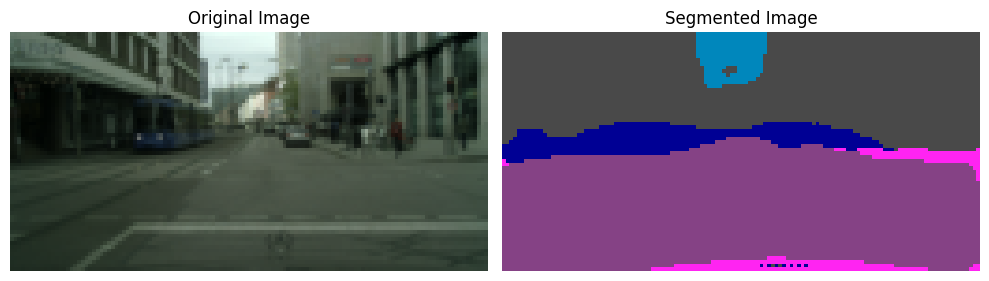

In [ ]:
show_images_side_by_side(imgs[4].detach().cpu(), test_dataset.decode_segmap(preds[4]).detach().cpu())

## Experiment 3

In [12]:
# Login into wandb

# Local
# wandb.login(key=os.getenv("WANDB_KEY"))

# Colab
wandb.login(key=WANDB_KEY)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: deniskirbaba (deniskirbaba-team). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
# Define run hyperparameters
config = dict(
    img_size=(128, 256),
    classes=N_CLASSES,
    architecture="UNet",
    start_channels=16,
    depth=4,
    epochs=10,
    batch_size=128,
    learning_rate=1e-3,
)

In [14]:
# Init and prepare trainer
trainer = Trainer(
    config=config,
    device=device,
    dtype=DTYPE,
    ignore_index=IGNORE_INDEX,
    idx2name=IDX2NAME,
    project_name="images_hw_1",
    model_save_folder=PROJECT_FOLDER_PATH / "model_checkpoints/experiment_3/"
    )

trainer.prepare(cityscapes_folder=CITYSCAPES_FOLDER, subset=False, compile=True)

Found 2975 train images
Found 500 val images


#### Analyze size of model

Batch size tuning happens here

In [15]:
trainer.model

OptimizedModule(
  (_orig_mod): UNet(
    (down_blocks): ModuleList(
      (0): DoubleConv(
        (layer): Sequential(
          (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Hardswish()
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): Hardswish()
        )
      )
      (1): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (layer): Sequential(
            (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
            (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [16]:
summary(
    trainer.model,
    input_data=torch.zeros(
        size=(config["batch_size"], 3, *config["img_size"]), dtype=DTYPE, device=device
    ),
    mode="train",
)

/usr/local/lib/python3.10/dist-packages/torch/_inductor/compile_fx.py:1604: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Layer (type:depth-idx)                             Output Shape              Param #
OptimizedModule                                    [128, 19, 128, 256]       --
├─UNet: 1-1                                        [128, 19, 128, 256]       --
│    └─ModuleList: 2-1                             --                        --
│    │    └─DoubleConv: 3-1                        [128, 16, 128, 256]       2,832
│    │    └─Sequential: 3-2                        [128, 32, 64, 128]        14,016
│    │    └─Sequential: 3-3                        [128, 64, 32, 64]         55,680
│    │    └─Sequential: 3-4                        [128, 128, 16, 32]        221,952
│    │    └─Sequential: 3-5                        [128, 256, 8, 16]         886,272
│    └─Sequential: 2-2                             [128, 256, 8, 16]         --
│    │    └─MaxPool2d: 3-6                         [128, 256, 4, 8]          --
│    │    └─DoubleConv: 3-7                        [128, 512, 4, 8]          3,542,016
│    │ 

#### Run pipeline

In [ ]:
model = trainer.run_model_pipeline()

#### Examples of model predictions

In [ ]:
# Load best model
model = torch.load(
    Path("???"), weights_only=False, map_location=device
)

In [18]:
# Let's pick 5 images from test dataset and predict classes from our model
test_dataset = Cityscapes(
    CITYSCAPES_FOLDER,
    split="test",
    is_transform=True,
    img_size=list(config["img_size"]),
    dtype=DTYPE,
)
test_loader = DataLoader(
    test_dataset, batch_size=5, shuffle=True, num_workers=multiprocessing.cpu_count()
)

imgs, lbls = next(iter(test_loader))
imgs.shape, imgs.dtype

Found 1525 test images


(torch.Size([5, 3, 128, 256]), torch.bfloat16)

In [19]:
# Get predictions from model
model.eval()
with torch.no_grad():
    logits = model(imgs.to(device))
    preds = logits.argmax(dim=1, keepdim=True)

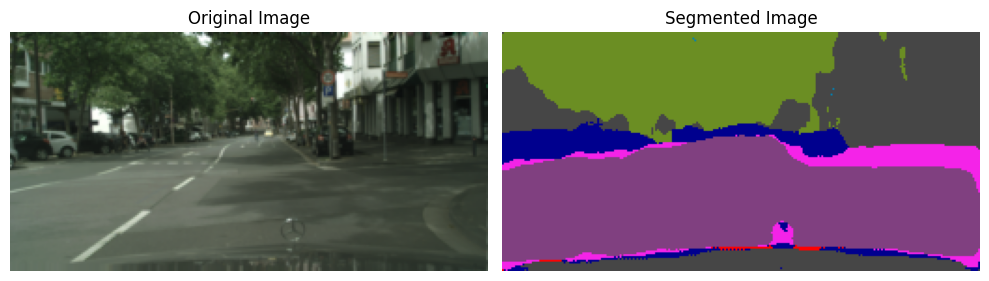

In [20]:
show_images_side_by_side(imgs[0].detach().cpu(), test_dataset.decode_segmap(preds[0]).detach().cpu())

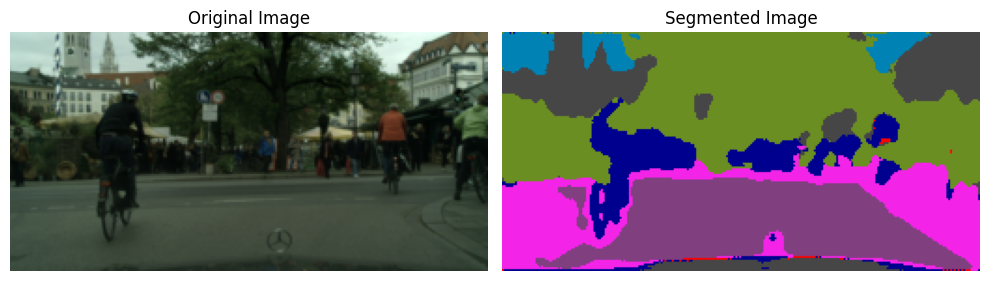

In [21]:
show_images_side_by_side(imgs[1].detach().cpu(), test_dataset.decode_segmap(preds[1]).detach().cpu())

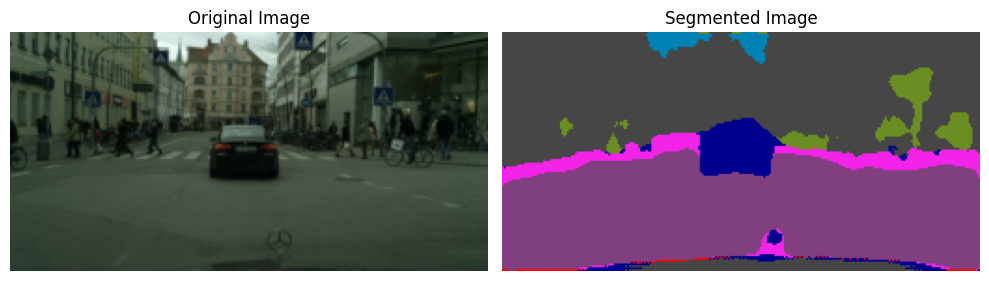

In [22]:
show_images_side_by_side(imgs[2].detach().cpu(), test_dataset.decode_segmap(preds[2]).detach().cpu())

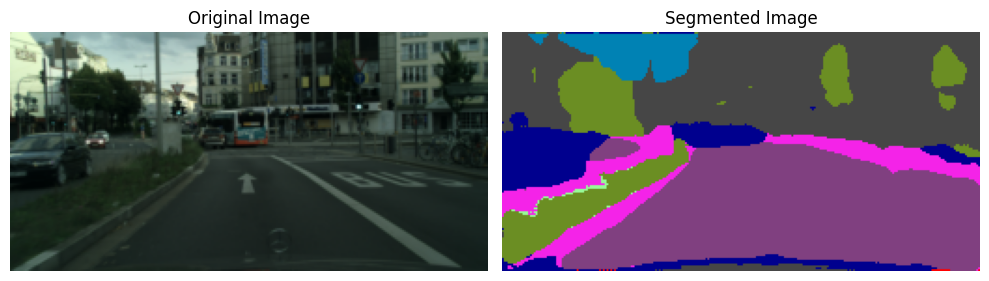

In [25]:
show_images_side_by_side(imgs[3].detach().cpu(), test_dataset.decode_segmap(preds[3]).detach().cpu())

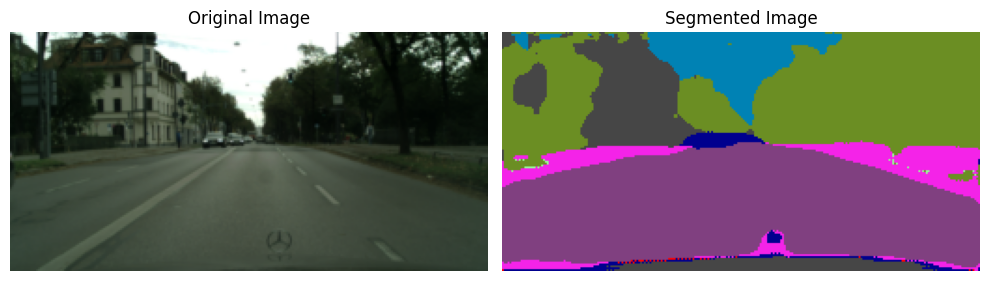

In [26]:
show_images_side_by_side(imgs[4].detach().cpu(), test_dataset.decode_segmap(preds[4]).detach().cpu())